# Variational Autoencoder

**task**
- clustering

**training**
1. Gibbs sampler
2. Variational Autoencoder

## 0. Initialize

In [1]:
using LinearAlgebra
using SparseArrays
using ForwardDiff
using Distributions
using Statistics
using Random
using Plots
using ProgressMeter
using UnPack
import PyPlot
pyplot()

Plots.PyPlotBackend()

## 1. Create data

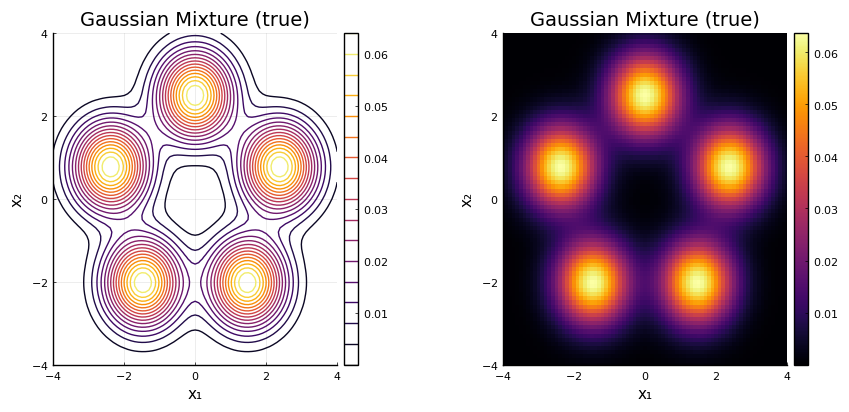

In [2]:
#Gaussian Mixture
trueK = 5
Σ = I(2)/2
ϕ = 2*π/5
μk(k, ϕ) = 2.5*[cos(π/2+k*ϕ), sin(π/2+k*ϕ)]
mixed_normal = MixtureModel([[MvNormal(μk(k, ϕ), Σ) for k in 1:trueK]...])
true_pdf(x) = pdf(mixed_normal, x)

#data
N = 80
Random.seed!(42)
X = rand(mixed_normal, N)
Dx, N = size(X)
data = (X=X, Dx=Dx, N=N)

#visualize
x1s = -4:0.1:4
x2s = -4:0.1:4
p1 = plot(x1s, x2s, (x,y)->true_pdf([x,y]), st=:contour, xlim=[-4,4], ylim=[-4,4], xlabel="x₁", ylabel="x₂")
p2 = plot(x1s, x2s, (x,y)->true_pdf([x,y]), st=:heatmap, xlim=[-4,4], ylim=[-4,4], xlabel="x₁", ylabel="x₂")
fig1 = plot(p1, p2, title="Gaussian Mixture (true)", size=(900, 400))
savefig(fig1, "figs-VAE/fig1.png")

## 2. Gibbs sampler

In [3]:
#model
pmodel(x, μs, λs, πs, K) = pdf(MixtureModel([[MvNormal(μs[:,k],1/√(λs[k])) for k in 1:K]...], πs), x)

#predictive
function ppred(x, param_samps, K)
    @unpack μsamps, λsamps, πsamps = param_samps
    K,S = size(πsamps)
    preds = zeros(S)
    for s in 1:S
        preds[s] = pmodel(x, μsamps[:,:,s], λsamps[:,s], πsamps[:,s], K)
    end
    return mean(preds)
end

#categorical
function rand_ctgr(prob)
    K = length(prob)
    zvec = zeros(K)
    zvec[rand(Categorical(prob))] = 1
    return zvec
end

#update
function updateμk(X, zks, λk, ρ, D, cnt)
    μmean = X*zks/(ρ+cnt)
    μstd = 1/sqrt((λk*(ρ+cnt)))
    return rand(MvNormal(μmean, μstd))
end
function updateλk(X, zks, μkvec, ρ, N, D, cnt)
    λkα = D*(1+cnt)/2 + 1
    λkβ = β + ρ*norm(μkvec)^2/2 + dot(sum((X-μkvec*ones(N)').^2, dims=1), zks)/2
    return rand(Gamma(λkα, 1/λkβ))
end
function update_prob(xn, μvec, λ, π, D, K)
    probs = zeros(K)
    for k in 1:K
        probs[k] = exp(-λ[k]*norm(xn-μvec[:,k])^2/2 + D*log(λ[k])/2 + log(π[k]))
    end
    return probs/sum(probs)
end
updateπ(αvec, cnts) = rand(Dirichlet(αvec + cnts))

function Gibbs_sampler(n_samps, n_burnin, data, model_params, inits)
    #initialize
    @unpack X,Dx,N = data
    @unpack β,ρ,αvec,K = model_params
    @unpack Zs₀,μs₀,λs₀,πs₀ = inits
    Zsamps = zeros(K,N)
    μsamps = zeros(Dx,K,n_samps)
    λsamps = zeros(K,n_samps)
    πsamps = zeros(K,n_samps)
    Zsamps = Zs₀
    μsamps[:,:,1] = μs₀
    λsamps[:,1] = λs₀
    πsamps[:,1] = πs₀
    Zprob = zeros(K,N)
    cnts = sum(Zsamps, dims=2)[:]
    @showprogress for s in 2:n_samps
        for k in 1:K
            μsamps[:,k,s] = updateμk(X, Zsamps[k,:], λsamps[k,s-1], ρ, Dx, cnts[k])
            λsamps[k,s] = updateλk(X, Zsamps[k,:], μsamps[:,k,s], ρ, N, Dx, cnts[k])
        end
        πsamps[:,s] = updateπ(αvec, cnts)
        for n in 1:N
            Zprob[:,n] = update_prob(X[:,n], μsamps[:,:,s], λsamps[:,s], πsamps[:,s], Dx, K)
            Zsamps[:,n] = rand_ctgr(Zprob[:,n])
        end
        cnts = sum(Zsamps, dims=2)[:]
    end
    return Zsamps, μsamps[:,:,n_burnin:end], λsamps[:,n_burnin:end], πsamps[:,n_burnin:end]
end

Gibbs_sampler (generic function with 1 method)

In [4]:
#parameters
β = 1
ρ = 1
K = 3
αvec = ones(K)
model_params = (β=β, ρ=ρ, αvec=αvec, K=K)

#initialize
πs₀ = rand(Dirichlet(αvec))
Zs₀ = zeros(K,N)
for n in 1:N
    Zs₀[:,n] = rand_ctgr(πs₀)
end
μs₀ = zeros(Dx,K)
λs₀ = ones(K)
inits = (Zs₀=Zs₀, μs₀=μs₀, λs₀=λs₀, πs₀=πs₀)

#sample
n_samps = 5000
n_burnin = div(n_samps, 10)
Zsamps, μsamps, λsamps, πsamps = Gibbs_sampler(n_samps, n_burnin, data, model_params, inits)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([0.0 0.0 … 0.0 0.0; 1.0 1.0 … 0.0 1.0; 0.0 0.0 … 1.0 0.0], [1.2802792586294327 -2.1615909250200236 -1.6082969114096863; 0.5799017933355715 0.6059795991191671 -2.3383580378898055]

[0.8481092159276666 -2.6686834894317406 -1.514709895526124; -0.11061538416211869 0.8783579650210839 -2.2638770188403843]

[0.542162528612335 -1.8108160096947163 -1.8577328016925894; 0.16374465152051954 0.8465550064934295 -1.6146770275437972]

...

[0.3786866726586574 -0.8452068610643659 2.6620146468079553; 2.0776367429264218 -1.0575505123008215 0.5944350130208071]

[0.1721242211024292 -0.898535716984936 2.5406659534293508; 2.0773785938920533 -0.6612013931106565 0.6410979265018846]

[-0.31601522423101275 -0.7208917111454606 2.6959805739076663; 2.3866006264479966 -0.864677647790725 0.37189412564789337], [0.3168008529165674 0.3814024858413352 … 0.9101072580624054 1.1400182968437305; 1.6058391497804052 1.4499094391594305 … 0.2883132661576224 0.29997032369059984; 1.8973994792265743 1.155374780714095 … 1.899529349

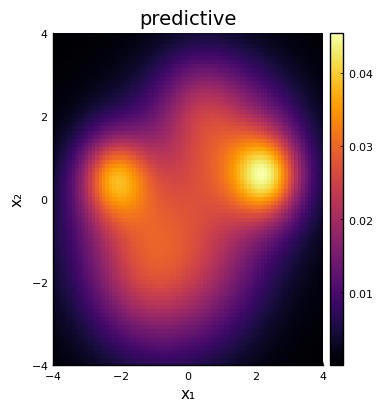

In [5]:
#show the result
samps = (μsamps=μsamps, λsamps=λsamps, πsamps=πsamps)
x1s = -4:0.1:4
x2s = -4:0.1:4
fig2 = plot(x1s, x2s, (x,y)->ppred([x,y], samps, K), st=:heatmap, xlim=[-4,4], ylim=[-4,4], xlabel="x₁", ylabel="x₂", title="predictive", size=(400,400))
savefig(fig2, "figs-VAE/fig2.png")

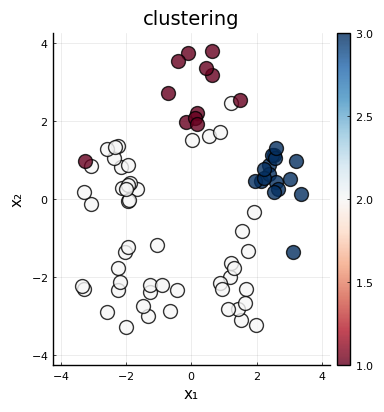

In [6]:
Zs = sum(collect(1:K) .* Zsamps, dims=1)[:]
fig3 = plot(xlabel="x₁", ylabel="x₂", title="clustering", label=false, size=(400,400), legend=false)
plot!(X[1,:], X[2,:], zcolor=Zs, st=:scatter, c=:RdBu, colorbar=:true, xlim=[-4,4], ylim=[-4,4], markersize=10, alpha=0.8)
savefig(fig3, "figs-VAE/fig3.png")

## 3. Variational Autoencoder

In [7]:
#initialize the parameter
function init_params(st)
    @unpack  DI, DO, DM = st
    W₂ = rand(DM, DI)
    W₃ = rand(DO, DM)
    b₂ = zeros(DM)
    b₃ = zeros(DO)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  DI, DO, DM = st
    W = reshape(wvec, (DI+DO+1, DM+1))
    W₂ = view(W, 2:DI+1, 1:DM)'
    W₃ = view(W, DI+2:DI+DO+1, 1:DM)
    b₂ = view(W, 1, 1:DM)
    b₃ = view(W, DI+2:DI+DO+1, DM+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function nn(x, wvec, st)
   @unpack  DI, DO, DM = st
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return W₃*σ.(W₂*x+b₂) + b₃
end
Φ(zvec, wvec, stΦ) = nn(zvec, wvec, stΦ)
Ψ(x, ηvec, stΨ) = nn(x, ηvec, stΨ)

#zn mean and precision
function mean_and_std(xn, ηvec, Dz, stΨ)
    tmp = Ψ(xn, ηvec, stΨ)
    mvec = tmp[1:Dz]
    svec = exp.(tmp[Dz+1:end])
    return mvec, svec
end

#reparameterization trick
g(θvec, uvec) = θvec[1:dw] + exp.(θvec[dw+1:end]) .* uvec
function h(ηvec, vvec, xn, Dz, stΨ)
    mvec, svec = mean_and_std(xn, ηvec, Dz, stΨ)
    return mvec + svec .* vvec
end

#logpmodel, ∇θlogpmodel
logpmodel(xn, znvec, wvec, σx, stΦ) = logpdf(MvNormal(Φ(znvec, wvec, stΦ), σx), xn)
∇θlogpmodel(θvec, uvec, xn, znvec, σx, stΦ) = ForwardDiff.gradient(θvec->logpmodel(xn, znvec, g(θvec, uvec), σx, stΦ), θvec)
∇ηlogpmodel(ηvec, vvec, xn, wvec, σx, Dz, stΦ, stΨ) = ForwardDiff.gradient(ηvec->logpmodel(xn, h(ηvec, vvec, xn, Dz, stΨ), wvec, σx, stΦ), ηvec)

#∇θLn(θ,η)
function ∇θI(θvec, xn, mvec, svec, σx, dw, Dz, stΦ, S, T)
    usvec = zeros(dw)
    zntvec = zeros(Dz)
    vals = zeros(2*dw,S,T)
    for s in 1:S
        usvec = rand(MvNormal(zeros(dw), ones(dw)))
        for t in 1:T
            zntvec = rand(MvNormal(mvec, svec))
            vals[:,s,t] = ∇θlogpmodel(θvec, usvec, xn, zntvec, σx, stΦ)
        end
    end
    return mean(mean(vals, dims=3), dims=2)[:]
end

#∇ηLn(θ,η)
function ∇ηI(θvec, ηvec, xn, σx, dw, dη, Dz, stΦ, stΨ, S, T)
    vsvec = zeros(Dz)
    wtvec = zeros(dw)
    vals = zeros(dη,S,T)
    for s in 1:S
        vsvec = rand(MvNormal(zeros(Dz), ones(Dz)))
        for t in 1:T
            wtvec = rand(MvNormal(θvec[1:dw], exp.(θvec[dw+1:end])))
            vals[:,s,t] = ∇ηlogpmodel(ηvec, vsvec, xn, wtvec, σx, Dz, stΦ, stΨ)
        end
    end
    return mean(mean(vals, dims=3), dims=2)[:]
end

#∇η| mvec |^2, ∇η| svec |^2, ∇η sum(log(svec))
∇ηnormsqmvec(ηvec, xn, stΨ, Dz) = ForwardDiff.gradient(ηvec->norm(Ψ(xn, ηvec, stΨ)[1:Dz])^2, ηvec)
∇ηnormsqsvec(ηvec, xn, stΨ, Dz) = ForwardDiff.gradient(ηvec->norm(exp.(Ψ(xn, ηvec, stΨ)[Dz+1:end]))^2, ηvec)
∇sumlogsvec(ηvec, xn, stΨ, Dz) = ForwardDiff.gradient(ηvec->sum(2*Ψ(xn, ηvec, stΨ)[Dz+1:end]), ηvec)
            
#gradient of approximation of ELBO Ln(θ,η)
function ∇θLn(θvec, xn, mvec, svec, σx, N, dw, Dz, stΦ, S, T)
    ∇θLns = N*∇θI(θvec, xn, mvec, svec, σx, dw, Dz, stΦ, S, T)
    for j in 1:dw
        ∇θLns[j] += -θvec[j]
        ∇θLns[dw+j] += -exp(2*θvec[dw+j]) + 1
    end
    return ∇θLns
end
function ∇ηLn(θvec, ηvec, xn, σx, N, dw, dη, Dz, stΦ, stΨ, S, T)
    tmp1 = ∇ηI(θvec, ηvec, xn, σx, dw, dη, Dz, stΦ, stΨ, S, T)
    tmp2 = ∇ηnormsqmvec(ηvec, xn, stΨ, Dz)
    tmp3 = ∇ηnormsqsvec(ηvec, xn, stΨ, Dz)
    tmp4 = ∇sumlogsvec(ηvec, xn, stΨ, Dz)
    return N*(tmp1-tmp2/2-tmp3/2+tmp4/2)
end

#variational infernce
function myVI(data, model_params, n_train, α)
    @unpack X,Dx,N = data
    @unpack σx,dw,dη,Dz,stΦ,stΨ,ηvec₀ = model_params
    θvec = vcat(zeros(dw), ones(dw))
    ηvec = ηvec₀
    mvec = zeros(Dz)
    svec = ones(Dz)
    S = 1
    T = 100
    @showprogress for k in 1:n_train
        idx = rand(1:N)
        xn = X[:,idx]
        mvec, svec = mean_and_std(xn, ηvec, Dz, stΨ)
        θvec += α * ∇θLn(θvec, xn, mvec, svec, σx, N, dw, Dz, stΦ, S, T)/k
        ηvec += α * ∇ηLn(θvec, ηvec, xn, σx, N, dw, dη, Dz, stΦ, stΨ, S, T)/k
    end
    return θvec, ηvec
end

myVI (generic function with 1 method)

In [8]:
#model params
Dz = 1
σx = 1.0

#initialize Neural Network (decoder)
DΦ = 5
stΦ = (DI=Dz, DO=Dx, DM=DΦ)
WΦ₂, WΦ₃, bΦ₂, bΦ₃ = init_params(stΦ)
WΦs = stick_params(WΦ₂, WΦ₃, bΦ₂, bΦ₃, stΦ.DI)
wvec₀ = WΦs[:]
dw = length(wvec₀)

#initialize Neural Network (encoder)
DΨ = 5
stΨ = (DI=Dx, DO=2*Dz, DM=DΨ)
WΨ₂, WΨ₃, bΨ₂, bΨ₃ = init_params(stΨ)
WΨs = stick_params(WΨ₂, WΨ₃, bΨ₂, bΨ₃, stΨ.DI)
ηvec₀ = WΨs[:]
dη = length(ηvec₀)

#model parameters
model_params = (σx=σx, dw=dw, dη=dη, Dz=Dz, stΦ=stΦ, stΨ=stΨ, ηvec₀)

#variational inference
n_train = 100

α = 0.001
params = (N=N, dw=dw, dη=dη, Dz=Dz, stΦ=stΦ, stΨ=stΨ)
θvec, ηvec = myVI(data, model_params, n_train, α)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


([-0.27387025644602175, -0.27279063856090097, -0.17141311395072423, -0.1886415728208901, -0.47188564442708664, -0.08775977630220443, -0.12508841043997404, 0.047153806266235686, 0.0007230489203923061, 0.08406748164497876  …  -0.4611410215999227, 0.2540552097978971, 0.8334526685680137, 0.9311464665802798, -0.40817120354930936, 0.515172635009212, 0.9679991033788072, 0.9679991033788072, -0.11355891654034045, -0.8184604864862298], [-0.07234666545521203, 0.5934317343413388, 0.829876313825174, 0.17197383399733993, 0.13518596373201394, -0.0776916717041201, 0.611222235688088, 0.3410821352880361, -0.006689311935094376, 0.07703827298464289  …  -0.13307872164506482, -0.17063550317645299, 0.488849293691047, 0.7904010505332746, 0.24976476718446133, 0.0, 0.0, 0.0, -0.358584694071396, -0.5899105496680187])

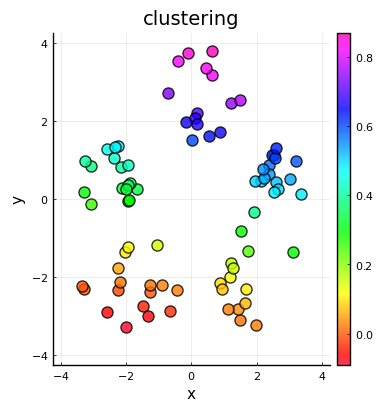

In [9]:
Zs = zeros(N)
for n in 1:N
    Zs[n] = Ψ(X[:,n], ηvec, stΨ)[1]
end
fig5 = plot(xlim=[-4,4], ylim=[-4,4], xlabel="x", ylabel="y", title="clustering", size=(400,400))
plot!(X[1,:], X[2,:], zcolor=Zs, st=:scatter, c=palette(:gist_rainbow), markersize=8, alpha=0.8, label=false)
savefig(fig5, "figs-VAE/fig4.png")